# Semantic Search (KNN) for Document Classification

This notebook uses K-Nearest Neighbors with semantic embeddings for document classification.

## Approach:
- Generate embeddings using multilingual sentence transformers
- Use KNN for similarity-based classification
- Test multiple distance metrics (cosine, euclidean)
- Experiment with different K values
- Local execution

## Setup:
- Model: `paraphrase-multilingual-MiniLM-L12-v2`
- GCS Bucket: `gosexpert_categorize`
- Split: 70% train / 30% test
- MLflow: Experiment tracking

## 1. Import Dependencies

In [23]:
# Standard library
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project root
project_root = Path().absolute().parent.parent
sys.path.insert(0, str(project_root))

# Data
import pandas as pd
import numpy as np

# Embeddings
from sentence_transformers import SentenceTransformer

# KNN and neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
import faiss  # Facebook AI Similarity Search (optional, faster)

# GCS and MLflow
from gcs_bucket_interface import GCSBucketInterface
from mlflow_recorder import MLflowRecorder

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Environment
from dotenv import load_dotenv
load_dotenv()

print("All imports successful!")

All imports successful!


## 2. Configuration

In [24]:
# Experiment configuration
EXPERIMENT_NAME = "semantic_search_knn_v1"
BUCKET_NAME = "gosexpert_categorize"
TRAIN_TEST_SPLIT = 0.3
RANDOM_STATE = 42
PAGES_TO_EXTRACT = 1  # ONLY FIRST PAGE!
MAX_CHARS = 1000  # Limit to first 1000 chars for better focus

# Model configuration
EMBEDDING_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"

# KNN configurations to test
K_VALUES = [1, 3, 5, 7, 10, 15]
DISTANCE_METRICS = ['cosine', 'euclidean', 'manhattan']

print(f"Configuration loaded")
print(f"Embedding Model: {EMBEDDING_MODEL}")
print(f"Pages to extract: {PAGES_TO_EXTRACT}")
print(f"Max characters: {MAX_CHARS}")
print(f"K values to test: {K_VALUES}")
print(f"Distance metrics: {DISTANCE_METRICS}")

Configuration loaded
Embedding Model: paraphrase-multilingual-MiniLM-L12-v2
Pages to extract: 1
Max characters: 1000
K values to test: [1, 3, 5, 7, 10, 15]
Distance metrics: ['cosine', 'euclidean', 'manhattan']


## 3. Load Documents

In [25]:
# Initialize GCS
gcs_interface = GCSBucketInterface(bucket_name=BUCKET_NAME)

print("Loading files from GCS...")
all_files = gcs_interface.list()

# Filter PDFs with tags
pdf_files_with_tags = []
for file_info in all_files:
    if file_info['name'].lower().endswith('.pdf') and file_info.get('metadata'):
        metadata = file_info['metadata']
        if any(key.startswith('tag') or 'category' in key.lower() for key in metadata.keys()):
            pdf_files_with_tags.append(file_info)

print(f"Found {len(pdf_files_with_tags)} PDFs")

# DataFrame
df_files = pd.DataFrame([{
    'file_name': f['name'],
    'gcs_uri': f['gcs_uri'],
    'tags': [v for k, v in f['metadata'].items() if 'tag' in k.lower()]
} for f in pdf_files_with_tags])

print(f"DataFrame: {df_files.shape}")

[GCSBucketInterface] Initialized for bucket: gosexpert_categorize
Loading files from GCS...
[GCSBucketInterface] Listed 561 files
Found 561 PDFs
DataFrame: (561, 3)


## 4. Load Pre-Extracted Text

In [26]:
TEXT_EXTRACTION_DIR = project_root / "text_extraction_results"

def load_text_from_json(json_filename: str, max_pages: int = PAGES_TO_EXTRACT, max_chars: int = MAX_CHARS) -> str:
    """Load text from JSON file - ONLY FIRST PAGE and limit characters."""
    json_path = TEXT_EXTRACTION_DIR / json_filename
    if not json_path.exists():
        return ""
    try:
        import json
        with open(json_path, 'r', encoding='utf-8') as f:
            page_data = json.load(f)
        
        # Only load first N pages
        text_parts = [page_data[f"page{i}"] for i in range(1, max_pages+1) if f"page{i}" in page_data]
        full_text = "\n".join(text_parts).strip()
        
        # LIMIT TO MAX_CHARS to focus on beginning (where document type is most obvious)
        return full_text[:max_chars]
    except:
        return ""

print("Loading text (FIRST PAGE ONLY, first 1000 chars)...")
texts, valid_indices = [], []
for idx, row in df_files.iterrows():
    text = load_text_from_json(row['file_name'].replace('.pdf', '.json'))
    if text:
        texts.append(text)
        valid_indices.append(idx)
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(df_files)}...")

df_files = df_files.loc[valid_indices].reset_index(drop=True)
df_files['text'] = texts
df_files['text_length'] = df_files['text'].str.len()

print(f"Loaded {len(df_files)} documents")
print(f"Average text length: {df_files['text_length'].mean():.0f} chars")
print(f"Max text length: {df_files['text_length'].max():.0f} chars")

Loading text (FIRST PAGE ONLY, first 1000 chars)...
Processed 50/561...
Processed 100/561...
Processed 150/561...
Processed 200/561...
Processed 250/561...
Processed 300/561...
Processed 350/561...
Processed 400/561...
Processed 450/561...
Processed 500/561...
Processed 550/561...
Loaded 382 documents
Average text length: 794 chars
Max text length: 1000 chars


## 5. Prepare Data

In [27]:
# Extract tags
def get_primary_tag(tags_list):
    return tags_list[0] if isinstance(tags_list, list) and len(tags_list) > 0 else "unknown"

df_files['primary_tag'] = df_files['tags'].apply(get_primary_tag)
df_files = df_files[df_files['primary_tag'] != "unknown"].reset_index(drop=True)

print(f"Documents: {len(df_files)}")
print(f"Unique tags: {df_files['primary_tag'].nunique()}")
print(f"\nTop 10 tags:")
print(df_files['primary_tag'].value_counts().head(10))

# Train/test split
tag_counts = df_files['primary_tag'].value_counts()
rare_tags = tag_counts[tag_counts < 2].index
valid_tags = tag_counts[tag_counts >= 2].index

if len(rare_tags) > 0:
    print(f"\n⚠️ {len(rare_tags)} rare tags")
    rare_df = df_files[df_files['primary_tag'].isin(rare_tags)]
    valid_df = df_files[df_files['primary_tag'].isin(valid_tags)]
    train_df, test_df = train_test_split(
        valid_df, test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_STATE,
        stratify=valid_df['primary_tag']
    )
    train_df = pd.concat([train_df, rare_df], ignore_index=True)
else:
    train_df, test_df = train_test_split(
        df_files, test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_STATE,
        stratify=df_files['primary_tag']
    )

print(f"\nSplit: Train={len(train_df)} | Test={len(test_df)}")

Documents: 382
Unique tags: 31

Top 10 tags:
primary_tag
Лицензия                              43
АПЗ                                   28
Отчет Геод                            24
ОПЗ                                   23
Отчет Геол                            22
Технические условия на подключение    22
Письмо о начале строительства         16
Авиация                               16
Письмо Заявка                         15
Смета ПИР                             14
Name: count, dtype: int64

⚠️ 1 rare tags

Split: Train=267 | Test=115


## 6. Generate Embeddings

In [28]:
print(f"Loading embedding model: {EMBEDDING_MODEL}...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
print("Model loaded!")

# Generate train embeddings
print("\nGenerating train embeddings...")
train_texts = train_df['text'].tolist()
train_embeddings = embedding_model.encode(
    train_texts,
    show_progress_bar=True,
    batch_size=32,
    normalize_embeddings=True  # Important for cosine similarity
)
print(f"Train embeddings: {train_embeddings.shape}")

# Generate test embeddings
print("\nGenerating test embeddings...")
test_texts = test_df['text'].tolist()
test_embeddings = embedding_model.encode(
    test_texts,
    show_progress_bar=True,
    batch_size=32,
    normalize_embeddings=True
)
print(f"Test embeddings: {test_embeddings.shape}")

# Labels
y_train = train_df['primary_tag'].values
y_test = test_df['primary_tag'].values

# Encode labels for sklearn compatibility (fixes manhattan metric issue)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2...
Model loaded!

Generating train embeddings...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Train embeddings: (267, 384)

Generating test embeddings...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Test embeddings: (115, 384)


## 7. Grid Search: Test Multiple KNN Configurations

In [29]:
print("="*60)
print("KNN GRID SEARCH")
print("="*60)

results = []

for k in K_VALUES:
    for metric in DISTANCE_METRICS:
        print(f"\nTesting K={k}, metric={metric}...")
        
        try:
            # Train KNN with encoded labels
            knn = KNeighborsClassifier(
                n_neighbors=k,
                metric=metric,
                n_jobs=-1
            )
            knn.fit(train_embeddings, y_train_encoded)
            
            # Predict (returns encoded labels)
            y_pred_encoded = knn.predict(test_embeddings)
            
            # Decode predictions back to original labels
            y_pred = label_encoder.inverse_transform(y_pred_encoded)
            
            # Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            results.append({
                'K': k,
                'Metric': metric,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1': f1
            })
            
            print(f"  Accuracy: {acc:.4f} | F1: {f1:.4f}")
            
        except Exception as e:
            print(f"  Error: {str(e)[:100]}")
            # Add failed result
            results.append({
                'K': k,
                'Metric': metric,
                'Accuracy': 0.0,
                'Precision': 0.0,
                'Recall': 0.0,
                'F1': 0.0
            })

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(results_df.to_string(index=False))

KNN GRID SEARCH

Testing K=1, metric=cosine...
  Accuracy: 0.4522 | F1: 0.4047

Testing K=1, metric=euclidean...
  Accuracy: 0.4087 | F1: 0.3677

Testing K=1, metric=manhattan...
  Accuracy: 0.4087 | F1: 0.3652

Testing K=3, metric=cosine...
  Accuracy: 0.4435 | F1: 0.3819

Testing K=3, metric=euclidean...
  Accuracy: 0.4435 | F1: 0.3819

Testing K=3, metric=manhattan...
  Accuracy: 0.4261 | F1: 0.3667

Testing K=5, metric=cosine...
  Accuracy: 0.4261 | F1: 0.3530

Testing K=5, metric=euclidean...
  Accuracy: 0.4261 | F1: 0.3530

Testing K=5, metric=manhattan...
  Accuracy: 0.4261 | F1: 0.3685

Testing K=7, metric=cosine...
  Accuracy: 0.4261 | F1: 0.3698

Testing K=7, metric=euclidean...
  Accuracy: 0.4261 | F1: 0.3680

Testing K=7, metric=manhattan...
  Accuracy: 0.4348 | F1: 0.3777

Testing K=10, metric=cosine...
  Accuracy: 0.4000 | F1: 0.3451

Testing K=10, metric=euclidean...
  Accuracy: 0.4000 | F1: 0.3451

Testing K=10, metric=manhattan...
  Accuracy: 0.3826 | F1: 0.3220

Testi

## 8. Best Configuration

In [30]:
# Find best configuration
best_idx = results_df['F1'].argmax()
best_k = results_df.iloc[best_idx]['K']
best_metric = results_df.iloc[best_idx]['Metric']
best_f1 = results_df.iloc[best_idx]['F1']

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"K: {int(best_k)}")
print(f"Distance Metric: {best_metric}")
print(f"Accuracy:  {results_df.iloc[best_idx]['Accuracy']:.4f}")
print(f"Precision: {results_df.iloc[best_idx]['Precision']:.4f}")
print(f"Recall:    {results_df.iloc[best_idx]['Recall']:.4f}")
print(f"F1 Score:  {best_f1:.4f}")
print("="*60)

# Train final model with best config (using encoded labels)
best_knn = KNeighborsClassifier(
    n_neighbors=int(best_k),
    metric=best_metric,
    n_jobs=-1
)
best_knn.fit(train_embeddings, y_train_encoded)

# Get predictions and decode
best_pred_encoded = best_knn.predict(test_embeddings)
best_pred = label_encoder.inverse_transform(best_pred_encoded)

BEST CONFIGURATION
K: 1
Distance Metric: cosine
Accuracy:  0.4522
Precision: 0.4168
Recall:    0.4522
F1 Score:  0.4047


## 9. Top-K Accuracy Analysis

In [31]:
# Calculate top-k accuracy for different k values
print("\nTop-K Accuracy Analysis:")
print("="*40)

# Get probability predictions
y_proba = best_knn.predict_proba(test_embeddings)

for k in [1, 3, 5, 10]:
    if k <= len(best_knn.classes_):
        # Get top-k predictions
        top_k_preds = np.argsort(y_proba, axis=1)[:, -k:]
        
        # Check if true label is in top-k (use encoded labels)
        y_test_enc_indices = y_test_encoded
        top_k_correct = np.array([true_idx in pred for true_idx, pred in zip(y_test_enc_indices, top_k_preds)])
        top_k_acc = top_k_correct.mean()
        
        print(f"Top-{k} Accuracy: {top_k_acc:.4f}")


Top-K Accuracy Analysis:
Top-1 Accuracy: 0.4522
Top-3 Accuracy: 0.4957
Top-5 Accuracy: 0.5478
Top-10 Accuracy: 0.5913


## 10. Detailed Classification Report

In [32]:
print("\nClassification Report (Best KNN):")
print("="*60)
print(classification_report(y_test, best_pred, zero_division=0))


Classification Report (Best KNN):
                                           precision    recall  f1-score   support

                                      АПЗ       0.64      0.88      0.74         8
                                  Авиация       0.80      0.80      0.80         5
                            Дефектный акт       0.00      0.00      0.00         1
 Дополнительная (корректировка/капремонт)       0.50      0.67      0.57         3
                           Заключение СЭС       0.00      0.00      0.00         1
                   Информация о заказчике       0.00      0.00      0.00         3
                                 Лицензия       0.67      0.77      0.71        13
                                     ОВОС       0.00      0.00      0.00         1
                                      ОПЗ       0.00      0.00      0.00         7
                               Отчет Геод       0.50      0.14      0.22         7
                               Отчет Геол       0.6

## 11. Confusion Matrix

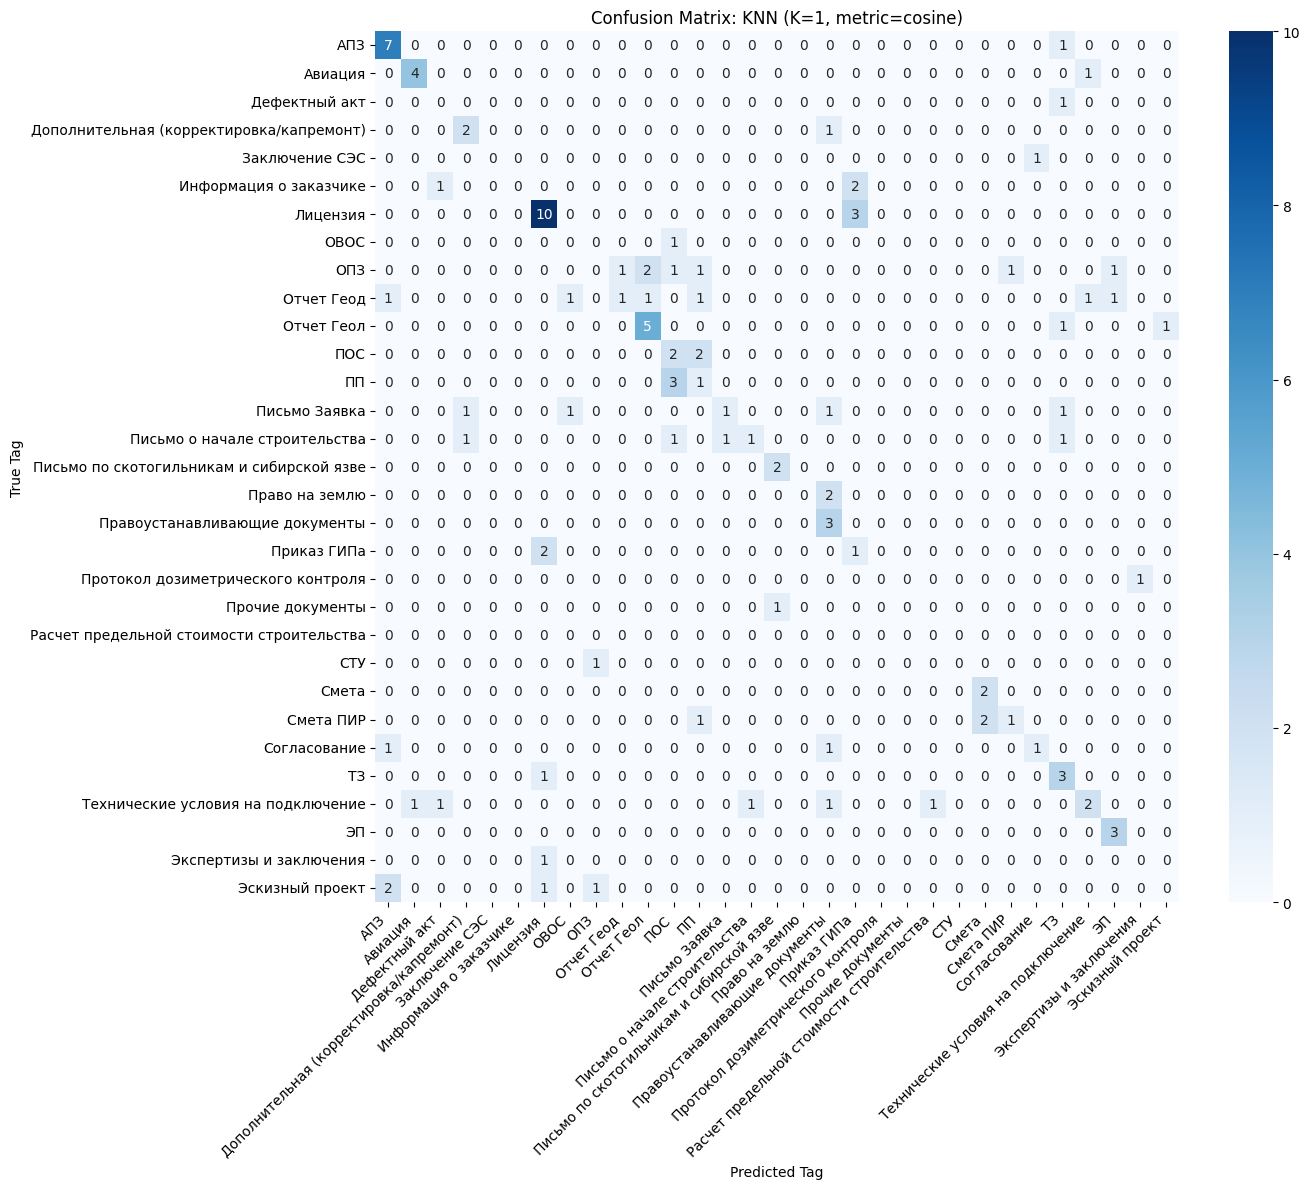

Confusion matrix saved!


In [33]:
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, best_pred)
labels = sorted(list(set(y_test.tolist() + best_pred.tolist())))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix: KNN (K={int(best_k)}, metric={best_metric})')
plt.ylabel('True Tag')
plt.xlabel('Predicted Tag')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

## 12. Grid Search Visualization

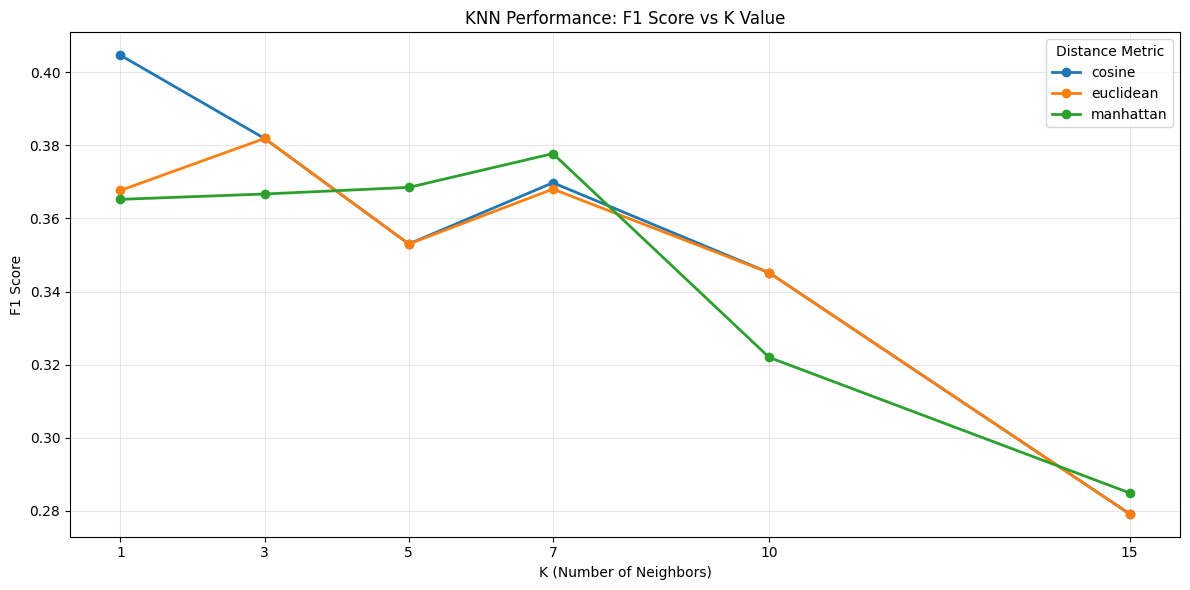

Grid search visualization saved!


In [34]:
# Plot F1 scores for different K values and metrics
fig, ax = plt.subplots(figsize=(12, 6))

for metric in DISTANCE_METRICS:
    metric_results = results_df[results_df['Metric'] == metric]
    ax.plot(metric_results['K'], metric_results['F1'], marker='o', label=metric, linewidth=2)

ax.set_xlabel('K (Number of Neighbors)')
ax.set_ylabel('F1 Score')
ax.set_title('KNN Performance: F1 Score vs K Value')
ax.legend(title='Distance Metric')
ax.grid(alpha=0.3)
ax.set_xticks(K_VALUES)

plt.tight_layout()
plt.savefig('knn_grid_search.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grid search visualization saved!")

## 13. Nearest Neighbor Examples

In [35]:
# Show examples of nearest neighbors for a few test samples
print("\nNearest Neighbor Examples:")
print("="*60)

# Get distances and indices of nearest neighbors
distances, indices = best_knn.kneighbors(test_embeddings[:5], n_neighbors=int(best_k))

for i, (test_idx, neighbor_indices, neighbor_distances) in enumerate(zip(range(5), indices, distances)):
    print(f"\nTest Sample {i+1}:")
    print(f"  True Tag: {y_test[test_idx]}")
    print(f"  Predicted Tag: {best_pred[test_idx]}")
    print(f"  Nearest Neighbors:")
    
    for j, (neighbor_idx, dist) in enumerate(zip(neighbor_indices, neighbor_distances), 1):
        neighbor_tag = y_train[neighbor_idx]
        print(f"    {j}. Tag: {neighbor_tag:30s} | Distance: {dist:.4f}")


Nearest Neighbor Examples:

Test Sample 1:
  True Tag: Лицензия
  Predicted Tag: Приказ ГИПа
  Nearest Neighbors:
    1. Tag: Приказ ГИПа                    | Distance: 0.0708

Test Sample 2:
  True Tag: Правоустанавливающие документы
  Predicted Tag: Правоустанавливающие документы
  Nearest Neighbors:
    1. Tag: Правоустанавливающие документы | Distance: 0.0000

Test Sample 3:
  True Tag: АПЗ
  Predicted Tag: АПЗ
  Nearest Neighbors:
    1. Tag: АПЗ                            | Distance: 0.1182

Test Sample 4:
  True Tag: Лицензия
  Predicted Tag: Лицензия
  Nearest Neighbors:
    1. Tag: Лицензия                       | Distance: 0.0429

Test Sample 5:
  True Tag: Письмо о начале строительства
  Predicted Tag: Письмо Заявка
  Nearest Neighbors:
    1. Tag: Письмо Заявка                  | Distance: 0.1369


## 14. Embedding Visualization (t-SNE)

Generating t-SNE visualization...
Note: This may take a few minutes...


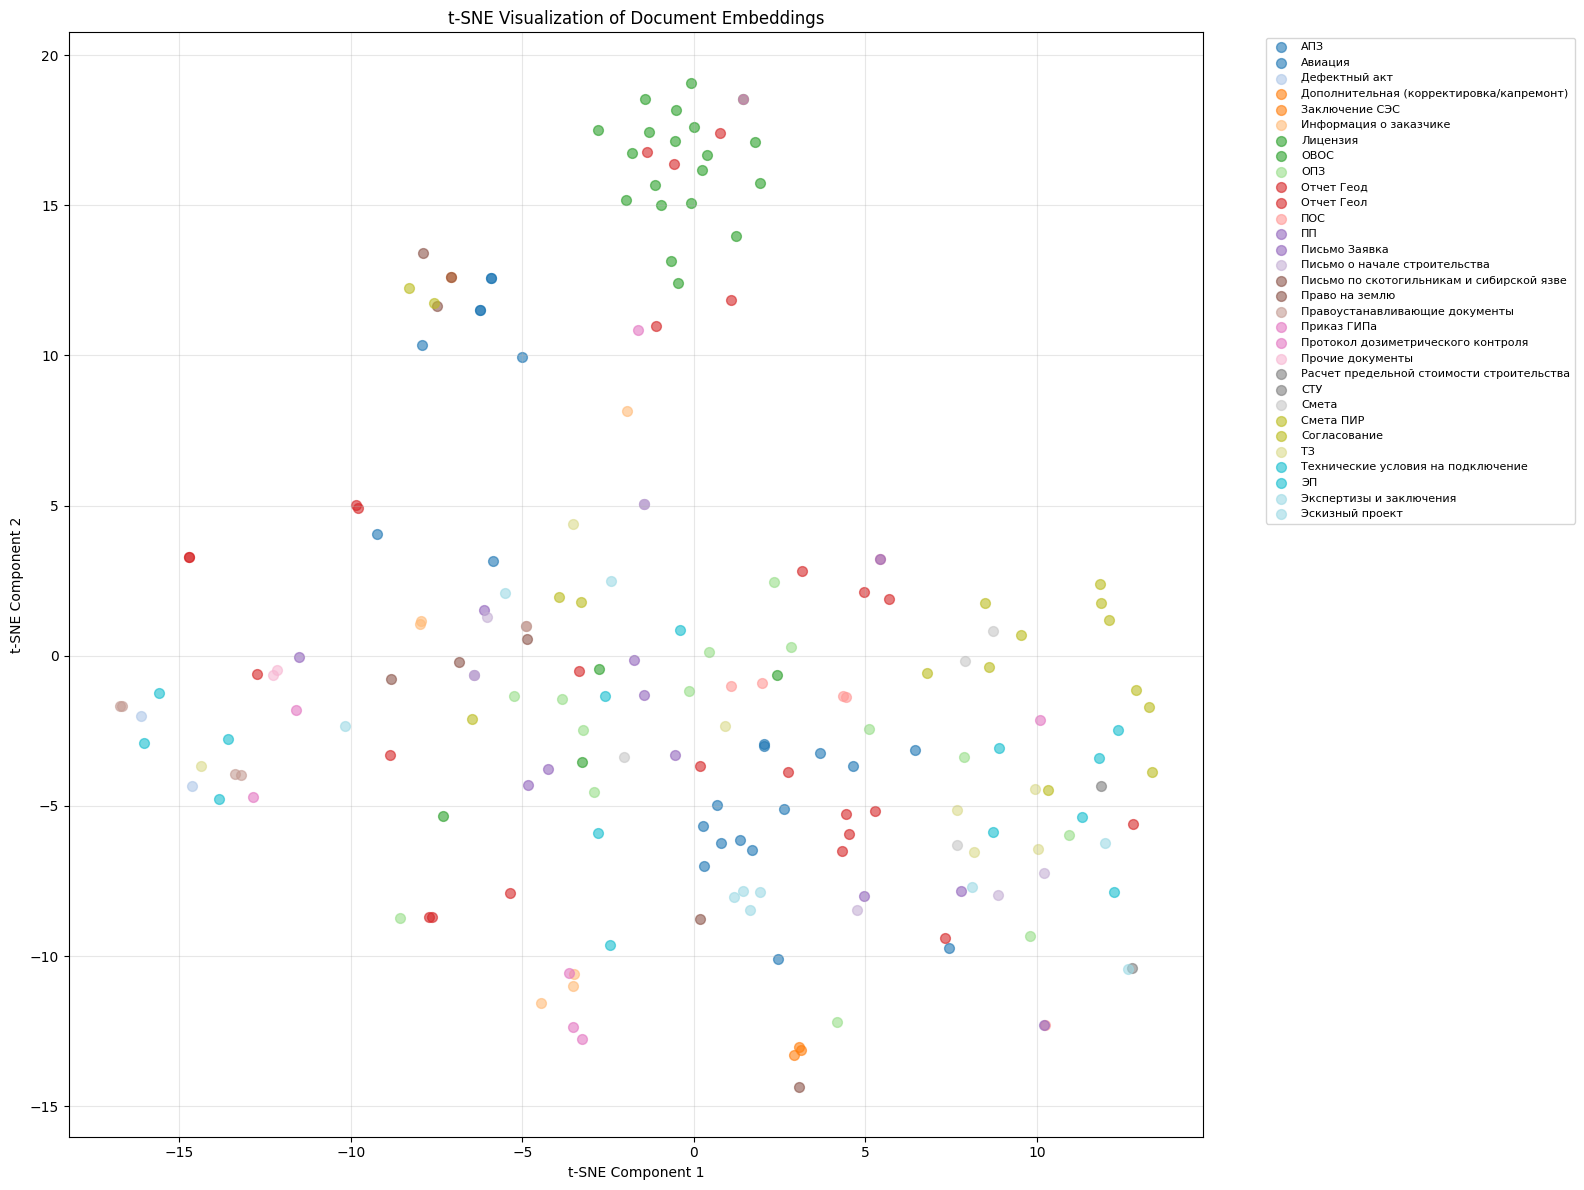

t-SNE visualization saved!


In [36]:
# Visualize embeddings using t-SNE (sample for performance)
print("Generating t-SNE visualization...")
print("Note: This may take a few minutes...")

# Sample documents for visualization (to speed up t-SNE)
n_samples = min(200, len(train_embeddings))
sample_indices = np.random.choice(len(train_embeddings), n_samples, replace=False)
sample_embeddings = train_embeddings[sample_indices]
sample_labels = y_train[sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot
plt.figure(figsize=(16, 12))
unique_labels = np.unique(sample_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = sample_labels == label
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[color],
        label=label,
        alpha=0.6,
        s=50
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title('t-SNE Visualization of Document Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('knn_tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved!")

## 15. Save Best Model

In [37]:
import joblib

model_dir = './knn_models'
os.makedirs(model_dir, exist_ok=True)

print(f"Saving KNN model...")
joblib.dump(best_knn, f'{model_dir}/best_knn_model.pkl')
np.save(f'{model_dir}/train_embeddings.npy', train_embeddings)
np.save(f'{model_dir}/train_labels.npy', y_train)

# Save metadata
metadata = {
    'embedding_model': EMBEDDING_MODEL,
    'best_k': int(best_k),
    'best_metric': best_metric,
    'embedding_dim': train_embeddings.shape[1],
    'num_classes': len(np.unique(y_train)),
    'accuracy': float(results_df.iloc[best_idx]['Accuracy']),
    'f1_score': float(best_f1)
}

import json
with open(f'{model_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model saved to {model_dir}/")

Saving KNN model...
Model saved to ./knn_models/


## 16. Log to MLflow

In [38]:
print("Logging to MLflow...")
mlflow_recorder = MLflowRecorder(experiment_name=EXPERIMENT_NAME)

# Parameters
params = {
    "embedding_model": EMBEDDING_MODEL,
    "embedding_dim": train_embeddings.shape[1],
    "train_size": len(train_df),
    "test_size": len(test_df),
    "num_classes": len(np.unique(y_train)),
    "best_k": int(best_k),
    "best_metric": best_metric
}
mlflow_recorder.log_params(params)

# Metrics
metrics = {
    "best_accuracy": float(results_df.iloc[best_idx]['Accuracy']),
    "best_precision": float(results_df.iloc[best_idx]['Precision']),
    "best_recall": float(results_df.iloc[best_idx]['Recall']),
    "best_f1": float(best_f1)
}
mlflow_recorder.log_metrics(metrics)

# Artifacts
mlflow_recorder.log_artifact('knn_confusion_matrix.png')
mlflow_recorder.log_artifact('knn_grid_search.png')
mlflow_recorder.log_artifact('knn_tsne_visualization.png')

# Tags
mlflow_recorder.set_tag("model_type", "knn_semantic_search")
mlflow_recorder.set_tag("distance_metric", best_metric)

mlflow_recorder.end_run()
print("MLflow logging complete!")

Logging to MLflow...


KeyboardInterrupt: 

## 17. Summary

In [39]:
print("="*60)
print("EXPERIMENT SUMMARY: SEMANTIC SEARCH (KNN)")
print("="*60)
print(f"Embedding Model: {EMBEDDING_MODEL}")
print(f"Embedding Dimension: {train_embeddings.shape[1]}")
print(f"\nDataset:")
print(f"  Train: {len(train_df)} | Test: {len(test_df)}")
print(f"  Classes: {len(np.unique(y_train))}")
print(f"\nBest Configuration:")
print(f"  K: {int(best_k)}")
print(f"  Distance Metric: {best_metric}")
print(f"\nPerformance:")
print(f"  Accuracy:  {results_df.iloc[best_idx]['Accuracy']:.4f}")
print(f"  Precision: {results_df.iloc[best_idx]['Precision']:.4f}")
print(f"  Recall:    {results_df.iloc[best_idx]['Recall']:.4f}")
print(f"  F1 Score:  {best_f1:.4f}")
print(f"\nModel saved to: {model_dir}/")
print("="*60)

EXPERIMENT SUMMARY: SEMANTIC SEARCH (KNN)
Embedding Model: paraphrase-multilingual-MiniLM-L12-v2
Embedding Dimension: 384

Dataset:
  Train: 267 | Test: 115
  Classes: 31

Best Configuration:
  K: 1
  Distance Metric: cosine

Performance:
  Accuracy:  0.4522
  Precision: 0.4168
  Recall:    0.4522
  F1 Score:  0.4047

Model saved to: ./knn_models/
